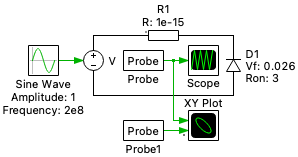

#### A simple, nonlinear circuit model
Originally implemented in PLECS. A resistor and a diode excited with a time harmonic signal (200 MHz).
This model determines the current drawn from the voltage source.

The goal is to use automatic differentiation to calculate $\partial i/\partial v$ which is needed
for the nonlinear Finite Element Method.

In [1]:
struct Dual{T <:Number} <:Number
     v::T
    dv::T
end

import Base: +, -, *, /
-(x::Dual)          = Dual(-x.v,       -x.dv)
+(x::Dual, y::Dual) = Dual( x.v + y.v,  x.dv + y.dv)
-(x::Dual, y::Dual) = Dual( x.v - y.v,  x.dv - y.dv)
*(x::Dual, y::Dual) = Dual( x.v * y.v,  x.dv * y.v + x.v * y.dv)
/(x::Dual, y::Dual) = Dual( x.v / y.v, (x.dv * y.v - x.v * y.dv)/y.v^2)

import Base: abs, sin, cos, tan, exp, log, sqrt, conj, abs2, isless
abs(x::Dual)  = Dual(abs(x.v),sign(x.v)*x.dv)
sin(x::Dual)  = Dual(sin(x.v), cos(x.v)*x.dv)
cos(x::Dual)  = Dual(cos(x.v),-sin(x.v)*x.dv)
tan(x::Dual)  = Dual(tan(x.v), one(x.v)*x.dv + tan(x.v)^2*x.dv)
exp(x::Dual)  = Dual(exp(x.v), exp(x.v)*x.dv)
log(x::Dual)  = Dual(log(x.v), x.dv/x.v)
sqrt(x::Dual) = Dual(sqrt(x.v),.5/sqrt(x.v) * x.dv)
conj(x::Dual) = x
abs2(x::Dual) = abs(x) * abs(x)
isless(x::Dual, y::Dual) = x.v < y.v;

import Base: convert, promote_rule
convert(::Type{Dual{T}}, x::Dual) where T = Dual(convert(T, x.v), convert(T, x.dv))
convert(::Type{Dual{T}}, x::Number) where T = Dual(convert(T, x), zero(T))
promote_rule(::Type{Dual{T}}, ::Type{R}) where {T,R} = Dual{promote_type(T,R)}

import Base: show
show(io::IO, x::Dual) = print(io, "(", x.v, ") + [", x.dv, "ε]");
value(x::Dual) = x.v;
partials(x::Dual) = x.dv;

ε = Dual(0., 1.)

(0.0) + [1.0ε]

In [2]:
mutable struct ElectricDevice{D, T}
    ti :: Int
    it :: Int
    D0 :: Matrix{T}
    D1 :: Matrix{T}
    xp :: Vector{T}
    up :: Vector{T}
    x  :: Vector{T}
    u  :: Vector{T}
    y  :: Vector{T}
end

function ElectricDevice{D, T}(D0, D1) where {D, T}
    N, M = size(D0[:,:])
    device = ElectricDevice{D, T}(
        0, 0, zeros(T, N, M), zeros(T, N, M),
        zeros(T, N), zeros(T, M),
        zeros(T, N), zeros(T, M), zeros(T, M)
    )
    device.D0 .= D0
    device.D1 .= D1
    return device
end

function natPreComm(state)
    if state.ti == 1 return 1 end
    if state.ti == 2 return 2 end
end

function forcedComm(state)
    if state.ti == 1 return 1 end
    if state.ti == 2 return 2 end
end

function natPostComm(state)
    u = state.u
    if state.ti == 1 return (u[1]  < -u[2]) ? 2 : 1 end
    if state.ti == 2 return (u[1]  >=-u[2]) ? 1 : 2 end
end

function update!(state)    
    if state.ti == 1 D = state.D0 end
    if state.ti == 2 D = state.D1 end
    state.y[:] .= D * state.u
end

function init!(state)
    state.ti = 1
    state.it = 0
end

function step!(state, excitation)
    state.u[1] = excitation
    state.u[2] = 0.026
    state.ti = natPreComm(state)
    state.ti = natPostComm(state)
    state.ti = forcedComm(state)
    update!(state)
    state.up .= state.u
end

step! (generic function with 1 method)

In [3]:
D0 = [ 0.0 0.0
      -1.0 0.0]
D1 = [-0.333333333333333204 -0.333333333333333204
      -0.999999999999999667  3.33333333333333261e-16]

d = ElectricDevice{:D, Dual{Float64}}(D0, D1)
init!(d)

t = range(0, 5e-9, step=0.01e-9)
u = zeros(length(t), 2)
y = zeros(length(t), 2)
dydu = zeros(length(t))

for i=1:length(t)
    step!(d, sin(2π * 2e8 * t[i]) .+ ε)
    u[i, :] .= value.(d.u)
    y[i, :] .= value.(d.y)
    dydu[i]  = partials(d.y[1])
end

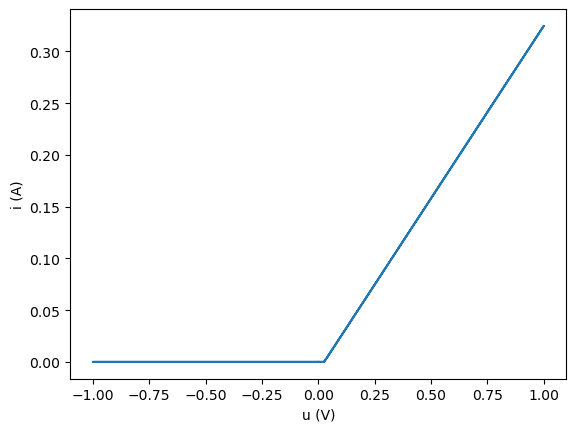

In [4]:
using PyPlot
plot(-u[:, 1], y[:, 1])
xlabel("u (V)")
ylabel("i (A)")
nothing

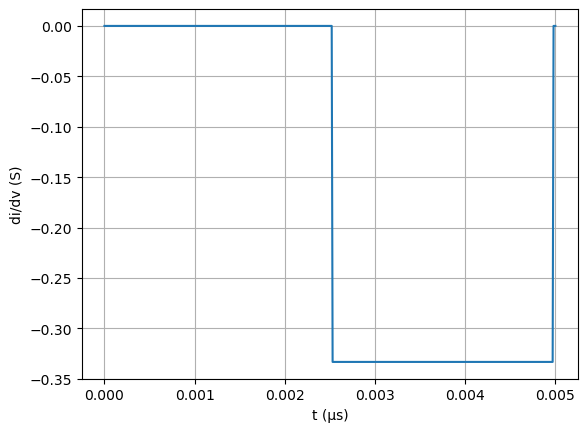

In [5]:
plot(1e6t, dydu)
xlabel("t (μs)")
ylabel("di/dv (S)")
grid();

In [6]:
using ACME

cir = @circuit begin
    v  = voltagesource(), [-] == gnd
    i  = currentprobe(),  [-] == gnd
    r1 = resistor(3e-3),  [1] == v[+]
    d1 = diode(is=1e-6),  [-] == r1[2], [+] == i[+]
end
nothing

In [7]:
Δt = 0.01e-9
model = DiscreteModel(cir, Δt)
u = [4.0sin(2π * 2e8 * ti) for ti in t]
y = run!(model, [ui for c in 1:1, ui in u])

1×501 Matrix{Float64}:
 0.0  8.66087e-7  9.82062e-7  9.97596e-7  …  -6.46754e-6  -3.91887e-20

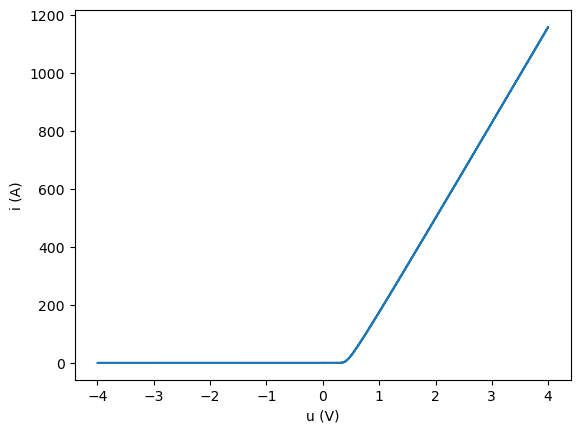

In [8]:
using PyPlot
plot(-u[:], -y[:])
xlabel("u (V)")
ylabel("i (A)")
nothing

In [9]:
M = ACME.model_matrices(cir, Δt)
M[:dq_full] .|> float

2×0 Matrix{BigFloat}

In [10]:
include("circuit-model.jl")
const DF = Dual{Float64}
const F64 = Float64
# M = model_matrices(cir, Δt)
A  = @SMatrix zeros(DF, 1,1) # M[:a]
B  = @SMatrix zeros(DF, 1,1) # M[:b]
C  = @SMatrix zeros(DF, 1,1) # mat[:c]
D  = @SMatrix zeros(DF, 4,1) # M[:di][element, :, :] or M[:dv][element, :, :]
E  = @SMatrix DF[ 1.0; 0.0; 0.0;-1.0 ] # M[:ei][element, :, :] or M[:ev][element, :, :]
F  = @SMatrix DF[ 1.0;-1.0;-1.0; 1.0 ] # M[:fi][element, :, :] or M[:fv][element, :, :]
Dq = @SMatrix zeros(DF, 2,1) # M[:dq_full]
Eq = @SMatrix DF[-1.0; 0.0] # M[:eq_full]
Fq = @SMatrix DF[-3e-3; 1.0] # M[:fq]
x̄  = zeros(DF, 1, 1)
y  = zeros(DF, 4, 1)
ū  = zeros(DF, 1, 1)
q̄  = zeros(DF, 2, 1)
z  = zeros(DF, 1, 1)
#m = DifferentiableModel(A, B, C, D, E, F, Dq, Eq, Fq,
#    zeros(DF, 1, 1), zeros(DF, 4, 1), zeros(DF, 1, 1),
#    zeros(DF, 2, 1), zeros(DF, 1, 1));

Is1, Is2 = 1e-4,  1e-4
Vt1, Vt2 = 25e-3, 25e-3
f(q) = @SMatrix[(Is1 * exp(q[1]/Vt1) - Is1 - q[2])]
df(q)= @SMatrix[(Is1 / Vt1 * exp(q[1]/Vt1)) -1.0]

df (generic function with 1 method)

In [11]:
function step!(A, B, C, D, E, F, Dq, Eq, Fq,
               x̄, y, ū, q̄, z, f, df)
    for _ in 1:1000
        q̄ .= Dq * x̄;
        q̄.+= Eq * ū;
        q̄.+= Fq * z;

        fq   =  f(q̄) # should be 0.0
        dfdq = df(q̄)
        dqdz = Fq

        dz = (dfdq * dqdz) \ fq
        z.-= dz
    end; println("Norm after nonlinear iterations: ", norm(value.(f(q̄))))
    
    y .= D * x̄;
    y.+= E * ū;
    y.+= F * z;
 
    x̄ .= A * x̄;
    x̄.+= B * ū;
    x̄.+= C * z;
end

step! (generic function with 5 methods)

In [12]:
ys = similar(t)
us = similar(t)
dydu = similar(t)
for i in 1:length(t)
    ū .= u[i] + ε
    step!(A, B, C, D, E, F, Dq, Eq, Fq,
          x̄, y, ū, q̄, z, f, df)
    us[i] = first(ū) |> value
    ys[i] = first(y) |> value
    dydu[i] = first(y) |> partials
end

Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
N

Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
Norm after nonlinear iterations: 0.0
N

Norm after nonlinear iterations: 3.410605131648481e-12
Norm after nonlinear iterations: 3.410605131648481e-12
Norm after nonlinear iterations: 6.139089236967266e-12
Norm after nonlinear iterations: 1.1596057447604835e-11
Norm after nonlinear iterations: 3.637978807091713e-12
Norm after nonlinear iterations: 1.4551915228366852e-11
Norm after nonlinear iterations: 1.000444171950221e-11
Norm after nonlinear iterations: 1.8417267710901797e-11
Norm after nonlinear iterations: 2.2737367544323206e-13
Norm after nonlinear iterations: 1.5916157281026244e-12
Norm after nonlinear iterations: 2.2509993868879974e-11
Norm after nonlinear iterations: 3.637978807091713e-12
Norm after nonlinear iterations: 2.3874235921539366e-11
Norm after nonlinear iterations: 6.139089236967266e-12
Norm after nonlinear iterations: 6.821210263296962e-12
Norm after nonlinear iterations: 2.2737367544323206e-12
Norm after nonlinear iterations: 1.8417267710901797e-11
Norm after nonlinear iterations: 2.091837814077735e-11
N

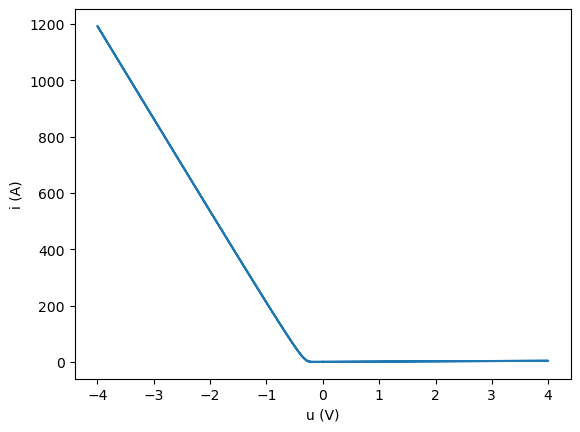

In [13]:
using PyPlot
plot(us[:], ys[:])
xlabel("u (V)")
ylabel("i (A)")
nothing

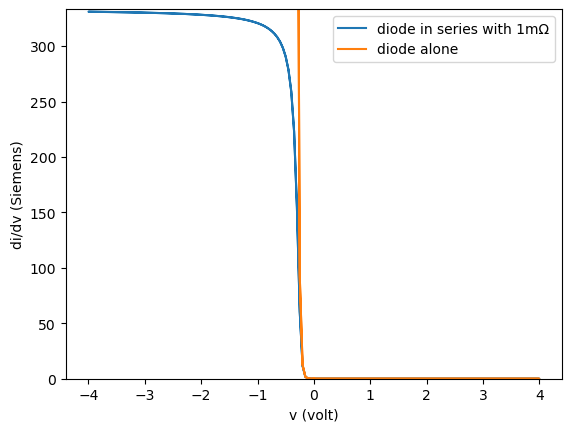

In [14]:
using PyPlot
plot(us[:], 1.0 .- dydu[:])
plot(us[:], Is1 / Vt1 * exp.(-us[:] ./ Vt1))
ylim([-0.01,+1/3e-3+0.01])
legend(("diode in series with 1mΩ", "diode alone"))
xlabel("v (volt)")
ylabel("di/dv (Siemens)")
nothing